In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_function_approximations(f, N=6, axs=None, large_labels=False):
    from scipy.interpolate import interp1d

    dt = 1e-3
    T = 1.0
    ts = np.arange(0, T, dt)
    ts_subs = np.linspace(0, 1, N)
    cmap = cm.get_cmap('tab10')

    def lollipop_plot(f, ax, color=None):
        color = cmap(0.0) if color is None else color
        for i, t in enumerate(ts_subs):
            ax.plot([t, t], [f(t), 0], 'k--')
            if large_labels:
                ax.text(t + 0.04 * (1 if i + 1 < len(ts_subs) else -1), f(t), '$y_{} = {:1.1f}$'.format(i + 1, f(t)),
                        va='center', ha='left' if i + 1 < len(ts_subs) else 'right',)
            else:
                ax.text(t + 0.06 * (1 if i + 1 < len(ts_subs) else -1), f(t), '$y_{}$'.format(i + 1, f(t)),
                        va='center', ha='left' if i + 1 < len(ts_subs) else 'right',
                        fontsize=8)
        ax.plot(ts_subs, f(ts_subs), 'o', linewidth=2, markersize=5, color=color)
        ax.plot(ts_subs, f(ts_subs), 'o', linewidth=2, markersize=15, markeredgewidth=2, markeredgecolor=color, markerfacecolor=(0.0, 0.0, 0.0, 0.0))

    def freq_rec(ts, ys):
        dt = (ts[-1] - ts[0]) / (len(ts) - 1)
        fs = np.fft.fftfreq(len(ts), dt)

        ss = 100 # super sampling
        dt2 = dt / ss
        ts2 = np.linspace(ts[0], ts[-1], len(ts) * ss)
        fs2 = np.fft.fftfreq(len(ts2), dt2)

        Ys = np.fft.fft(ys)
        Ys2 = np.zeros_like(fs2, dtype=np.complex)

        # This is extremely inefficient, but fine for this use-case
        for i, f in enumerate(fs):
            for j, f2 in enumerate(fs2):
                if np.abs(f - f2) < 1e-4:
                    Ys2[j] = Ys[i]
        ys2 = np.real(np.fft.ifft(Ys2))

        ts2 = (ts2 / ts2[len(ts2) - ss])[:-ss+1]
        ys2 = (ys2 * ss)[:-ss+1]

        return ts2, ys2

    def plot_reconstruction(ts, ys, ax, title, color):
        rmse = np.sqrt(np.mean(np.square(f(ts) - ys)))
        ax.plot(ts, f(ts), 'k:', linewidth=0.5)
        ax.plot(ts, ys, color=color)
        lollipop_plot(f, ax)
        ax.set_title('{} ($N = {}$; RMSE=${:0.1}$)'.format(title, N, rmse))

    if axs is None:
        fig, axs = plt.subplots(3, 2, figsize=(6.5, 3.5), sharex=True, sharey=True)
    else:
        fig = None
    for i, ax in enumerate(axs.flatten()):
        ax.set_xlim(0, T)
        ax.set_ylim(-1.5, 1.5)
        if not fig or i >= 4:
            ax.set_xlabel("$t$")
        if not fig or i % 2 == 0:
            ax.set_ylabel("$f(t)$")

    axs[0, 0].plot(ts, f(ts), linewidth=2)
    axs[0, 0].set_title('Continuous function')

    axs[0, 1].plot(ts, f(ts), 'k:', linewidth=0.5)
    lollipop_plot(f, axs[0, 1])
    axs[0, 1].set_title('Sampled function ($N = {}$)'.format(N))

    plot_reconstruction(
        ts, interp1d(ts_subs, f(ts_subs), 'linear')(ts),
        axs[1, 0], 'Linear interpolation', cmap(0.1))

    plot_reconstruction(
        ts, interp1d(ts_subs, f(ts_subs), 'quadratic')(ts),
        axs[1, 1], 'Quadratic interpolation', cmap(0.2))

    plot_reconstruction(
        ts, interp1d(ts_subs, f(ts_subs), 'cubic')(ts),
        axs[2, 0], 'Cubic interpolation', cmap(0.3))

    plot_reconstruction(
        *freq_rec(ts_subs, f(ts_subs)),
        axs[2, 1], 'Nyquist reconstruction', cmap(0.4))

    if not fig is None:
        fig.tight_layout(h_pad=0.5)

    return fig, axs

In [3]:
def make_function_plots(name, f, N):
    fig, _ = plot_function_approximations(f, N=N)
    fig.savefig('../{}_q{}_small.pdf'.format(name, N), bbox_inches='tight', transparent=True)

    axs = np.array([[plt.subplots(figsize=(6.5, 2.25))[1] for j in range(2)] for i in range(3)])
    plot_function_approximations(f, N=N, axs=axs, large_labels=True)
    for i, ax in enumerate(axs.flatten()):
        ax.get_figure().savefig('../{}_q{}_{}.pdf'.format(name, N, i + 1), bbox_inches='tight', transparent=True)

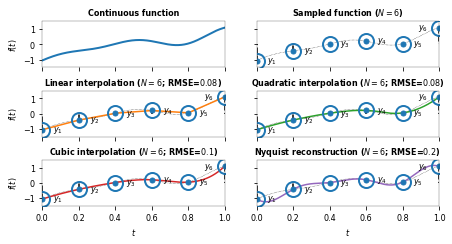

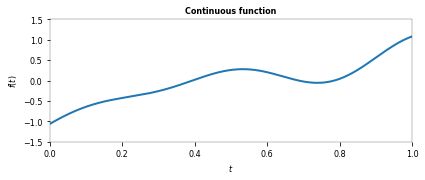

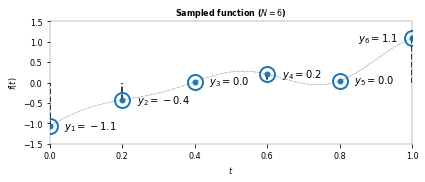

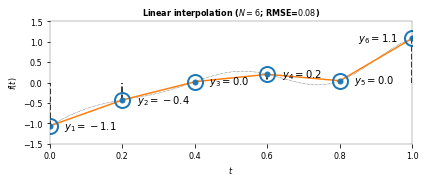

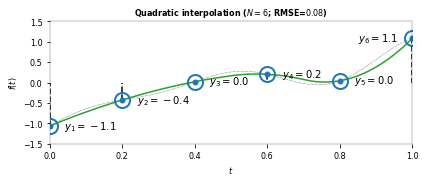

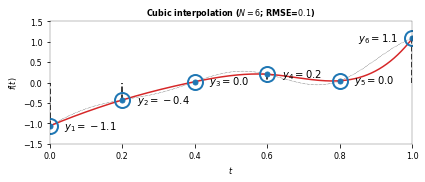

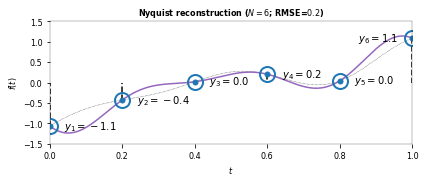

In [4]:
f = lambda x: 4 * (-(x - 0.5) ** 2 + (x - 0.25) ** 3 + 0.1 * np.cos(4 * np.pi * x) * np.abs(x))
make_function_plots('fun_1', f, 6)

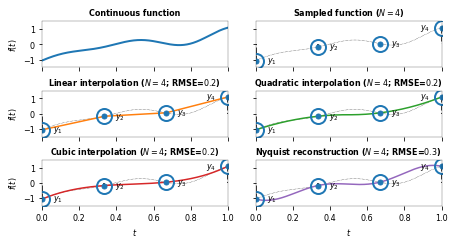

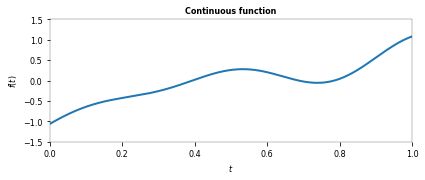

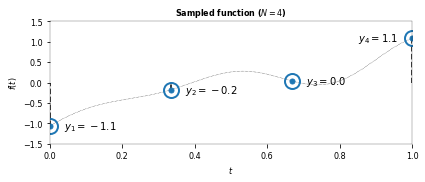

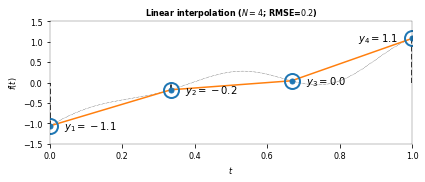

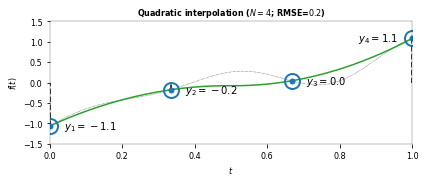

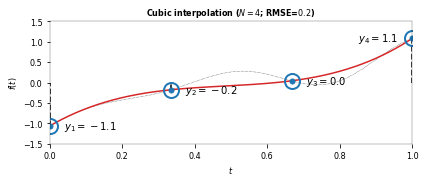

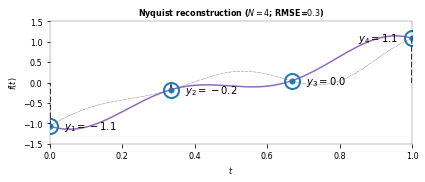

In [5]:
make_function_plots('fun_1', f, 4)

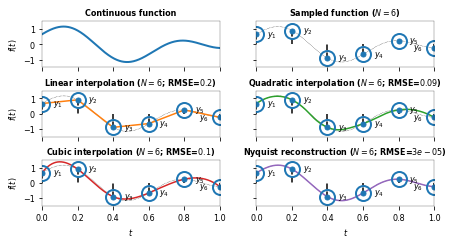

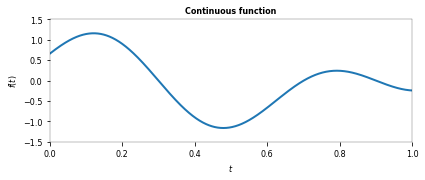

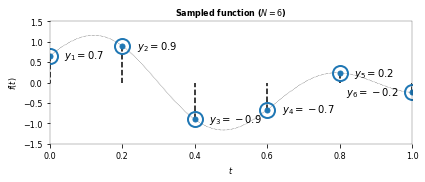

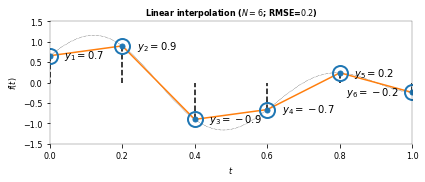

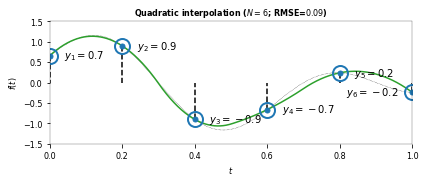

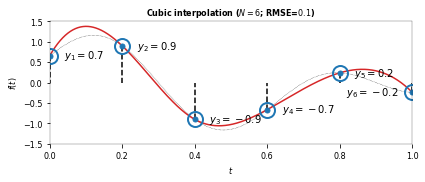

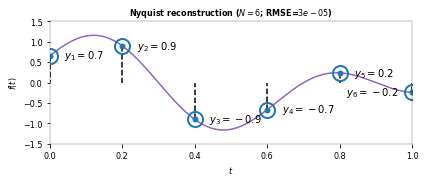

In [6]:
f = lambda x: 0.66 * (np.sin(1.6666 * x * 2.0 * np.pi) + np.cos(0.8333 * x * 2.0 * np.pi))
make_function_plots('fun_2', f, 6)

In [7]:
def plot_function_in_basis_space(title, ts, ys, basis):
    q = basis.shape[0]
    coeff = np.linalg.lstsq(basis.T, ys, rcond=None)[0]

    fig, axs = plt.subplots(2, 1, figsize=(6.5, 3), sharex=True)
    for i in range(q):
        axs[0].plot(ts, basis[i], label="$\\phi_{{{}}}$".format(i + 1))
    axs[0].set_ylabel('$\\vec \\phi(t)$')
    axs[0].set_title('{} ($q = {}$)'.format(title, q))
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(-2, 1.25)
    axs[0].legend(
        ncol=q,
        handlelength=1.0,
        handletextpad=0.25,
        columnspacing=1.0,
    )

    axs[1].plot(ts, ys, 'k:', linewidth=1)
    axs[1].plot(ts, coeff @ basis, linewidth=2)
    axs[1].set_ylabel('$\\hat f(t)$')
    axs[1].set_xlabel('$t$')
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(-1.5, 1.5)
    axs[1].text(0.975, -0.9, "RMSE = ${:1.2}$".format(np.sqrt(np.mean(np.square(ys - coeff @ basis)))), ha="right", fontsize=9)
    axs[1].text(0.025, 0.9, "$\\hat f(t) = {}$".format(" + ".join(filter(bool, map(
        lambda x: "{1:1.2f} \\phi_{{{0}}}(t)".format(x[0] + 1, x[1]) if np.abs(x[1]) > 0.01 else None, enumerate(coeff)
    ))).replace(" + -", " - ")), fontsize=7)

    return fig

def make_basis_plots(basis, f, name, title):
    ts = np.linspace(0, 1, basis.shape[1])
    q = basis.shape[0]

    for i in range(q):
        fig = plot_function_in_basis_space(title, ts, f(ts), basis[:i+1])
        fig.savefig('../{}_q{}.pdf'.format(name, i + 1), bbox_inches='tight', transparent=True)

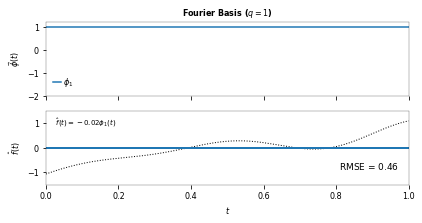

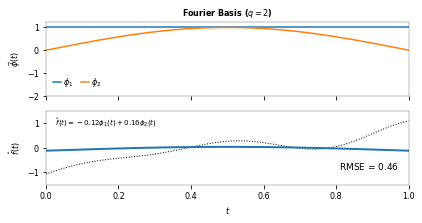

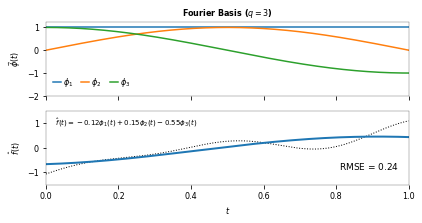

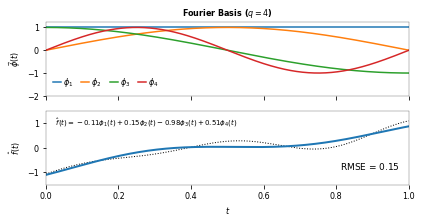

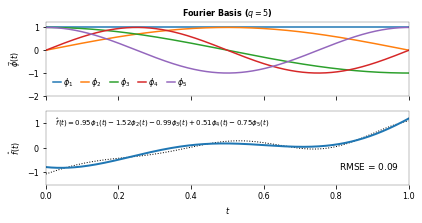

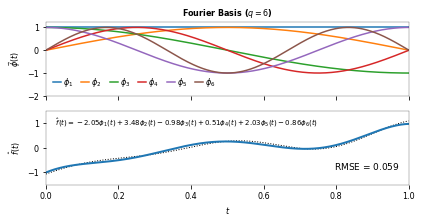

In [8]:
T, dt = 1.0, 1e-3
ts = np.arange(0, T, dt)
basis = np.array([
    np.cos(((n + 1) // 2) * np.pi * ts) * (n % 2 == 0) +
    np.sin(((n + 1) // 2) * np.pi * ts) * (n % 2 == 1) for n in range(6)])
f = lambda x: 4 * (-(x - 0.5) ** 2 + (x - 0.25) ** 3 + 0.1 * np.cos(4 * np.pi * x) * np.abs(x))
make_basis_plots(basis, f, 'fourier', 'Fourier Basis')

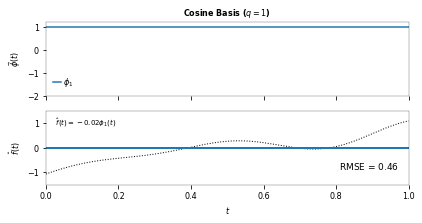

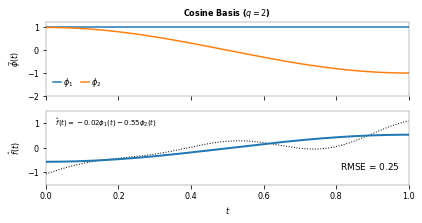

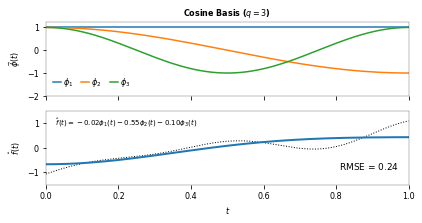

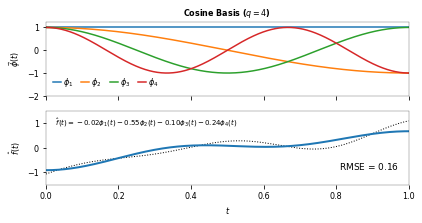

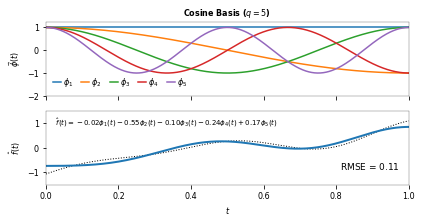

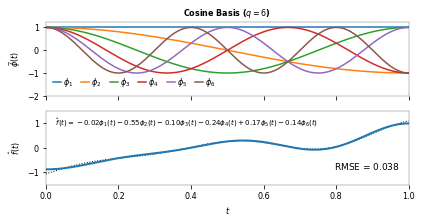

In [9]:
basis = np.array([np.cos(n * np.pi * ts) for n in range(6)])
f = lambda x: 4 * (-(x - 0.5) ** 2 + (x - 0.25) ** 3 + 0.1 * np.cos(4 * np.pi * x) * np.abs(x))
make_basis_plots(basis, f, 'cosine', 'Cosine Basis')

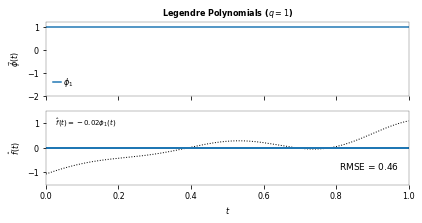

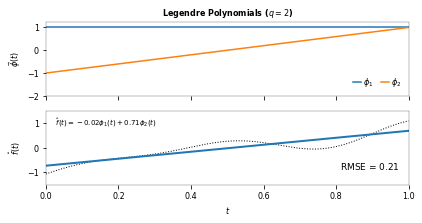

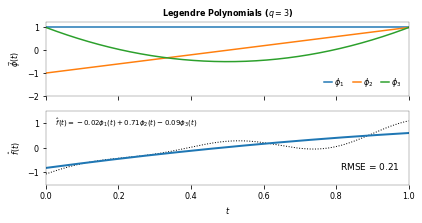

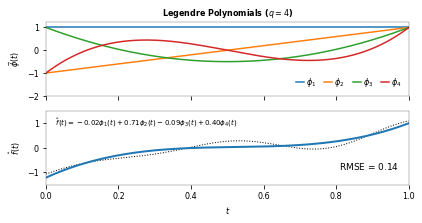

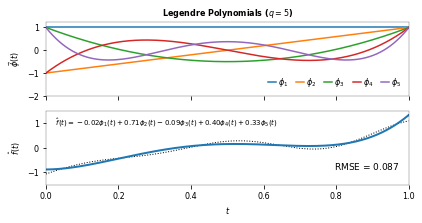

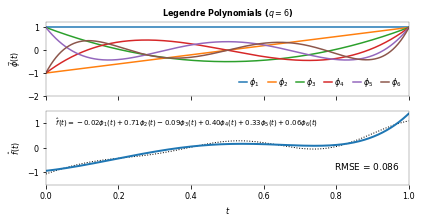

In [10]:
basis = np.array([np.polynomial.Legendre([0] * n + [1], [0, 1])(ts) for n in range(6)])
f = lambda x: 4 * (-(x - 0.5) ** 2 + (x - 0.25) ** 3 + 0.1 * np.cos(4 * np.pi * x) * np.abs(x))
make_basis_plots(basis, f, 'legendre', 'Legendre Polynomials')

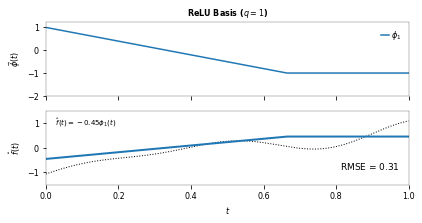

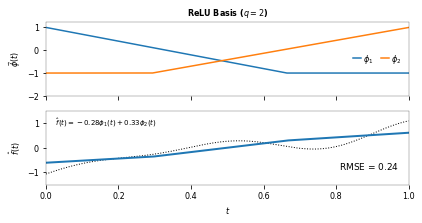

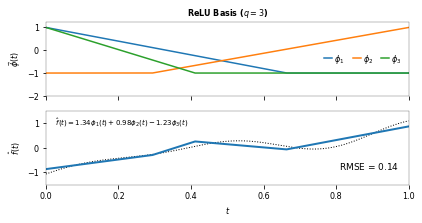

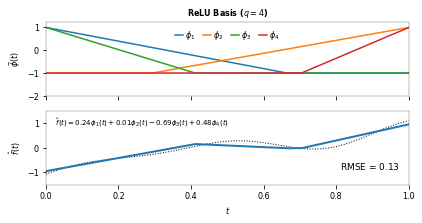

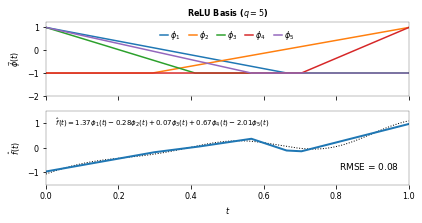

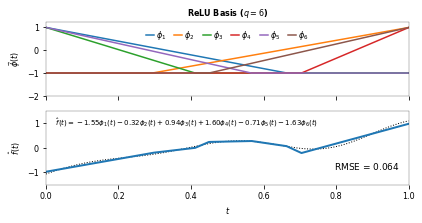

In [11]:
np.random.seed(4984)
N = 6
ξs = np.random.uniform(-1, 1, N)
Es = np.random.choice([-1, 1], N)

αs = 1 / (1 - ξs)
βs = ξs / (ξs - 1)

basis = np.array([2.0 * np.maximum(0, Es[n] * αs[n] * 2.0 * (ts - 0.5) + βs[n]) - 1.0 for n in range(N)])
f = lambda x: 4 * (-(x - 0.5) ** 2 + (x - 0.25) ** 3 + 0.1 * np.cos(4 * np.pi * x) * np.abs(x))
make_basis_plots(basis, f, 'neural', 'ReLU Basis')